# Evaluating BGP catchment on Tangled testbed
* Joao Ceron - ceron@botlog.org

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
plt.style.use('default')
from IPython.core.display import display, HTML
%matplotlib inline
from matplotlib import ticker
import os.path
import re
import numpy as pynum_float
%matplotlib inline


In [2]:
# convert names to airport code
di = {"uk-lnd-anycast02": "LHR", 
      'us-mia-anycast01':"MIA", 
      "au-syd-anycast01":"SYD",
      'fr-par-anycast01': "CDG",
      'jp-hnd-anycast01': "HND",
      'br-poa-anycast01': "POA",
      'us-was-anycast01': "IAD",
      'us-los-anycast01': "LAX",
      "nl-ens-anycast02": "ENS",
      'vultr-nodes' : 'vultr-nodes',
      'ampath-nodes' : 'ampath-nodes',
      'unknown': 'unknown',
      'baseline': 'baseline',
      'all': 'baseline',
     }
di_short = {
      "uk-lnd": "LHR", 
      'us-mia':"MIA", 
      "au-syd":"SYD",
      'fr-par': "CDG",
      'jp-hnd': "HND",
      'br-poa': "POA",
      'us-was': "IAD",
      'us-los': "LAX", 
      'nl-ens': "ENS",
      'vultr-nodes' : 'vultr-nodes',
      'ampath-nodes' : 'ampath-nodes',
      'unknown': 'unknown',
      'baseline': 'baseline',
      'all': 'baseline'
}

In [3]:
# plt.style.available[:5]

---
---
<h1 align="center">Functions</h1>

---
---

In [4]:
def init_fig(width=12,height=5):
    
    fig = plt.figure(figsize=(width, height))
    ax = plt.subplot(111)   
    ax.set_facecolor("#ffffff")
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    fig.tight_layout();
    plt.style.use('default')
    
    return (fig,ax)

In [5]:
def get_and_plot_reference_value(df,site):

    
    df_site = df[df['site']==site].sort_values(by="bgp")
    reference_value = df_site[df_site.bgp=="baseline"].iloc[0,2]

    label = "[{}%] BASELINE".format(int(reference_value))
    # reference value annotation
    ax.annotate(label,xy=(25, reference_value), ha='right',color='black',va='bottom')
    # reference value line
    ax.axhline(y=reference_value, xmin=-1, xmax=1.0, color='grey', linestyle='dotted')

    return (reference_value)

In [6]:
!pwd

/Users/ceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load


---
---
<h1 align="center">Read files and build dataframe</h1>

---
---

In [123]:
# get files, parse them and use their names
df_all = pd.DataFrame()

dir   = "/Users/ceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load/new-files/3-sites-new/*load*sort"
dir   = "/Users/ceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load/new-files/5-sites-new/*load*sort"
dir   = "/Users/ceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load/new-files/7-sites-new/*load*sort"

# dir   = "/Volumes/4T/dataset/2020-01-28-1580170039/load/*load*txt"
# /Volumes/4T/dataset/last/load
# dir = "/Volumes/4T/dataset/last/load/*load*.txt"
# dir = "/Users/ceron/work/SAND/catchment_manipulation/load-stats/*load*.txt"
# dir = "/Users/joaoceron/work/SAND/catchment_manipulation/load-stats/*load*.txt"
# dir = "/tmp/*load*.txt"

count = 0
for file in (glob.glob(dir)):
    count +=1
    filename = os.path.basename(file)
#     print ("working on file: {}".format(filename))
    
    
    # read header of stats load file
    fd = open(file, 'r') 
    for line in fd.readlines():
        if ("date" in line):
            id = line.split(",")[1].rstrip('\n')
        elif ("bgp_policy" in line):
            bgp = line.split(",")[1].rstrip('\n')
        elif ("active_nodes" in line):
            active_nodes = line.split(",")[1].rstrip('\n')
    ###
    ### BUILD Dataframe using load files 
    ###
    print (filename)
    #1 - process the baseline stats file - regular prefixes announcemnt
    if (bool(re.search('baseline', filename))):     
        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)       
        df['bgp_policy'] = "baseline"
        df['time'] = id
        df['bgp_policy_location'] = "all"
        df['num_prepend'] = 0
        df['community'] = "None"
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 
        
    # 2 - process prepend files
    elif re.search(r'(?=.*\bprepend\b.*)(?!.*\bvultr\b.*)(?!.*\bcommunity\b.*)(?!.*\bampath\b.*).*$', filename, re.M):

        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)  
        site = re.search('.*(\w{2}-\w+)-anycast\d{2}', bgp).group(1)
        num_prepend = int(re.search('.*-(\d)x-.*anycast\d{2}', bgp).group(1))

        if (bool(re.search('negative', bgp))):
            num_prepend = num_prepend*-1

        df['bgp_policy'] = "prepend"
        df['time'] = id
        df['bgp_policy_location'] = site
        df['num_prepend'] = num_prepend
        df['community'] = "None"
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 
            
    # 3 - process communities load files
    elif re.search(r'(?=.*\bcommunit\b.*)(?!.*\bvultr\b.*)(?!.*\bampath\b.*).*$', filename, re.M):
            
        print ("community {}".format(filename))
        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)  
        site = re.search('.*(\w{2}-\w+)-anycast\d{2}', bgp).group(1)
        community = (re.search('community-([0-9:,]+)-\w\w-.*cast\d\d',bgp).group(1))
        df['bgp_policy'] = "community"
        df['time'] = id
        df['bgp_policy_location'] = site
        df['num_prepend'] = 0
        df['community'] = community
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 

    # 4 - node withdraw
    elif (bool(re.search('-withdraw', filename))): 
        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)  
        site = re.search('.*(\w{2}-\w+)-anycast\d{2}', bgp).group(1)
        df['bgp_policy'] = bgp
        df['time'] = id
        df['bgp_policy_location'] = site
        df['num_prepend'] = 0
        df['community'] = "None"
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 

    # vultr prepending
    elif re.search(r'(?=.*\bprepend\b.*)(?=.*\bvultr\b.*).*$', filename, re.M):
        df = pd.read_csv(file,names=['site', 'count','percent'], skiprows=4)  
        df['time'] = id
        df['bgp_policy_location'] = "vultr-nodes"
        df['num_prepend'] = int(re.search('.*-(\d)x-.*node.*', bgp).group(1))
        df['community'] = "None"
        bgp = "-".join(str(x) for x in bgp.split("-")[0:2]).replace('-regular_positive','')
        df['bgp_policy'] = bgp
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        found = df[df['count']==500034]['count']
        if (int(found.count())>0):
            print ("vultr prepending")
        df_all = pd.concat([df, df_all],sort=False) 

        
    # ampath prepending
    elif re.search(r'(?=.*\bprepend\b.*)(?=.*\bampath\b.*).*$', filename, re.M): 
        df = pd.read_csv(file,names=['site', 'count','percent'], skiprows=4)
        df['time'] = id
        df['bgp_policy_location'] = "ampath-nodes"
        df['num_prepend'] = int(re.search('.*-(\d)x-.*node.*', bgp).group(1))
        df['community'] = "None"
        bgp = "-".join(str(x) for x in bgp.split("-")[0:2]).replace('-regular_positive','')
        df['bgp_policy'] = bgp
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3) 
        df_all = pd.concat([df, df_all],sort=False) 

    
print ("Files loaded: {}".format(count))
df=df_all
df['site']  =  df['site'].map(di)
df['bgp_policy_location']  =  df['bgp_policy_location'].map(di_short)


# df.to_csv("catchment-load-communities-prepend.csv", sep=';')

# remove prepend vs community prepend experiment from df (keep on df_all)
df = df[~df['bgp_policy_location'].str.contains("nodes")]
df_all.head()

load-new-prepend-positive-4x-br-poa-1586099710.txt.sort
load-new-prepend-negative-4x-au-syd-1586099710.txt.sort
load-new-community-20473:6601-fr-par-anycast01-1586099710.txt.sort
load-new-prepend-positive-5x-fr-par-1586099710.txt.sort
load-new-prepend-negative-1x-us-los-1586099710.txt.sort
load-new-prepend-negative-2x-nl-ens-1586099710.txt.sort
load-new-community-20473:6003-uk-lnd-anycast02-1586099710.txt.sort
load-new-prepend-positive-2x-us-los-1586099710.txt.sort
load-new-prepend-positive-1x-nl-ens-1586099710.txt.sort
load-new-prepend-negative-2x-br-poa-1586099710.txt.sort
load-new-prepend-negative-1x-au-syd-1586099710.txt.sort
load-new-prepend-positive-1x-br-poa-1586099710.txt.sort
load-new-prepend-positive-2x-au-syd-1586099710.txt.sort
load-new-#ipv4,au-syd-2020-04-05-1586099710.txt.sort
load-new-community-20473:6000-fr-par-anycast01-1586099710.txt.sort
load-new-prepend-positive-4x-nl-ens-1586099710.txt.sort
load-new-prepend-negative-3x-fr-par-1586099710.txt.sort
load-new-prepend-n

,site,count,percent,bgp_policy,time,bgp_policy_location,num_prepend,community
0,SYD,633845,10.347,prepend,,ENS,2,None
1,POA,1010776,16.500,prepend,,ENS,2,None
2,CDG,172306,2.813,prepend,,ENS,2,None
3,HND,1,0.000,prepend,,ENS,2,None
4,ENS,356215,5.815,prepend,,ENS,2,None


In [124]:
!pwd

/Users/ceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load


---
---
<h1 align="center">Baseline Catchment</h1>

---
---

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,count,percent,bgp_policy,time,bgp_policy_location,num_prepend,community
site,,,,,,,
SYD,609942,9.957,baseline,,baseline,0,None
POA,931086,15.200,baseline,,baseline,0,None
CDG,238858,3.899,baseline,,baseline,0,None
HND,1,0.000,baseline,,baseline,0,None
ENS,476153,7.773,baseline,,baseline,0,None
LHR,902864,14.739,baseline,,baseline,0,None
unknown,2527118,41.254,baseline,,baseline,0,None
MIA,439734,7.178,baseline,,baseline,0,None


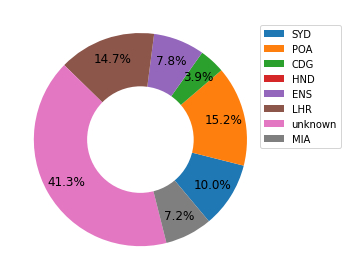

In [140]:

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot2grid((1,1), (0,0))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if (val==0):
            return ""
        return '{p:.1f}%'.format(p=pct,v=val)
    return my_autopct

result = df[df['bgp_policy'].str.contains("baseline")].copy()
result.set_index('site',inplace=True)
result.plot(ax=ax, 
            y='percent',
            autopct=make_autopct(result['count']),
            startangle=-50, 
            pctdistance=0.8, 
            kind="pie",
            fontsize=12,
            labels=None)

labels=result.index
ax.legend(labels, loc='upper center', bbox_to_anchor=(1.1,0.95))

centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle);
ax.set_ylabel('')
fig.tight_layout()
fig.show()
result

---
---
<h1 align="center">Catchment investigation using prepends</h1>

---
---

# OVERALL

## A - positive prepend

In [141]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data
# # data = data[data['num_prepend']=0]
# # data[data.bgp_policy_location=="HND"]580228
# # data[data['count'==580228]]
# data[data['count']==500034]

,site,count,percent,bgp_policy,time,bgp_policy_location,num_prepend,community
0,SYD,633845,10.347,prepend,,ENS,2,None
1,POA,1010776,16.500,prepend,,ENS,2,None
2,CDG,172306,2.813,prepend,,ENS,2,None
3,HND,1,0.000,prepend,,ENS,2,None
4,ENS,356215,5.815,prepend,,ENS,2,None
...,...,...,...,...,...,...,...,...
3,HND,1,0.000,prepend,,POA,4,None
4,ENS,637204,10.402,prepend,,POA,4,None
5,LHR,1027763,16.778,prepend,,POA,4,None
6,unknown,2534962,41.382,prepend,,POA,4,None


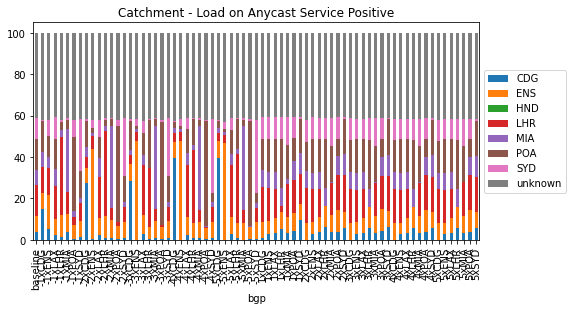

In [142]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot2grid((1,1), (0,0))
data.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
ax.set_title("Catchment - Load on Anycast Service Positive".format(site));  
data

data['sites'] = "5-sites"
# data.to_csv("5sites.csv")

# PLAYBOOK

In [143]:
data.columns

Index(['CDG', 'ENS', 'HND', 'LHR', 'MIA', 'POA', 'SYD', 'unknown', 'sites'], dtype='object', name='site')

In [144]:
# data =  data[[ 'LHR', 'MIA', 'SYD']]
data =  data[['CDG', 'ENS', 'HND', 'LHR', 'MIA', 'POA', 'SYD' ]]
data.apply(lambda x: x / x.sum())
data = data.div(data.sum(axis=1), axis=0).mul(100)
data.head()

site,CDG,ENS,HND,LHR,MIA,POA,SYD
bgp,,,,,,,
baseline,6.637048,13.231539,0.0,25.089368,12.218704,25.874102,16.949239
-1xCDG,25.811018,13.470071,0.0,21.118420,13.098876,25.341413,1.160201
-1xENS,8.848642,28.091419,0.0,23.013368,8.641656,17.528245,13.876671
-1xLAX,4.279142,12.883093,0.0,26.960287,13.620526,24.682024,17.574927
-1xLHR,2.086007,18.611063,0.0,65.606034,5.396220,7.220392,1.080284


In [146]:
data_cat = pd.DataFrame()
for site in data.columns:
    cat_site_label = site+"_CAT"
    data_cat[cat_site_label] = pd.cut(data[site],[0,10,20,30,40,50,60,70,80,90,100], include_lowest=True)
data_cat.head()

,CDG_CAT,ENS_CAT,HND_CAT,LHR_CAT,MIA_CAT,POA_CAT,SYD_CAT
bgp,,,,,,,
baseline,"(-0.001, 10.0]","(10.0, 20.0]","(-0.001, 10.0]","(20.0, 30.0]","(10.0, 20.0]","(20.0, 30.0]","(10.0, 20.0]"
-1xCDG,"(20.0, 30.0]","(10.0, 20.0]","(-0.001, 10.0]","(20.0, 30.0]","(10.0, 20.0]","(20.0, 30.0]","(-0.001, 10.0]"
-1xENS,"(-0.001, 10.0]","(20.0, 30.0]","(-0.001, 10.0]","(20.0, 30.0]","(-0.001, 10.0]","(10.0, 20.0]","(10.0, 20.0]"
-1xLAX,"(-0.001, 10.0]","(10.0, 20.0]","(-0.001, 10.0]","(20.0, 30.0]","(10.0, 20.0]","(20.0, 30.0]","(10.0, 20.0]"
-1xLHR,"(-0.001, 10.0]","(10.0, 20.0]","(-0.001, 10.0]","(60.0, 70.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 10.0]"


In [148]:
for site in data_cat.columns:
    print (site)
    print (data_cat[site].value_counts().sort_index())

CDG_CAT
(-0.001, 10.0]    62
(10.0, 20.0]       4
(20.0, 30.0]       1
(30.0, 40.0]       0
(40.0, 50.0]       2
(50.0, 60.0]       0
(60.0, 70.0]       2
(70.0, 80.0]       0
(80.0, 90.0]       0
(90.0, 100.0]      0
Name: CDG_CAT, dtype: int64
ENS_CAT
(-0.001, 10.0]     5
(10.0, 20.0]      61
(20.0, 30.0]       1
(30.0, 40.0]       0
(40.0, 50.0]       0
(50.0, 60.0]       0
(60.0, 70.0]       0
(70.0, 80.0]       1
(80.0, 90.0]       3
(90.0, 100.0]      0
Name: ENS_CAT, dtype: int64
HND_CAT
(-0.001, 10.0]    71
(10.0, 20.0]       0
(20.0, 30.0]       0
(30.0, 40.0]       0
(40.0, 50.0]       0
(50.0, 60.0]       0
(60.0, 70.0]       0
(70.0, 80.0]       0
(80.0, 90.0]       0
(90.0, 100.0]      0
Name: HND_CAT, dtype: int64
LHR_CAT
(-0.001, 10.0]    18
(10.0, 20.0]      10
(20.0, 30.0]      34
(30.0, 40.0]       1
(40.0, 50.0]       4
(50.0, 60.0]       1
(60.0, 70.0]       2
(70.0, 80.0]       1
(80.0, 90.0]       0
(90.0, 100.0]      0
Name: LHR_CAT, dtype: int64
MIA_CAT
(-0.001,

In [66]:
# data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data

In [69]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data
# data = data.drop(['HND',"unknown"],axis=1)
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
data.head()

site,HND,LHR,MIA,SYD,unknown
bgp,,,,,
baseline,0.0,34.828,10.618,10.413,44.141
-1xLHR,0.0,47.783,7.827,0.340,44.050
-1xMIA,0.0,17.825,26.271,0.265,55.640
-1xSYD,0.0,21.896,3.550,30.268,44.287
-2xLHR,0.0,49.957,5.685,0.337,44.021


In [70]:
# a = data.apply(lambda x: pd.cut(x,[0,10,20,30,40,50,60,70,80,90,100], include_lowest=True)) 
# a.fillna(pd.categorical("(0, 10]"))
# a.add_categories("(0, 10]").fillna("(0, 10]")
# b = a.reset_index()
# pd.pivot_table(b,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
b =data.reset_index()
b.head(1)

site,bgp,HND,LHR,MIA,SYD,unknown
0,baseline,0.0,34.828,10.618,10.413,44.141


In [61]:
for site in b.columns[1:]:
#     print (site)
    low = 90
    upper = 100
    size = b[(b.loc[:,['bgp',site]][site]>=low) & (b.loc[:,['bgp',site]][site]<upper) ][site]
    print ("{}-{}  {} {} ".format(low,upper, site,len(size)))
    b[(b.loc[:,['bgp',site]][site]>=low) & (b.loc[:,['bgp',site]][site]<upper) ][site]

90-100  CDG 0 
90-100  HND 0 
90-100  IAD 0 
90-100  LHR 0 
90-100  MIA 0 
90-100  POA 0 
90-100  SYD 0 
90-100  unknown 0 


#### site = "CDG"
b[(b.loc[:,['bgp',site]][site]>10) & (b.loc[:,['bgp',site]][site]<100) ][site]

In [18]:
for index, row in b.iterrows():
    print (row['bgp'],)

baseline
-1xCDG
-1xHND
-1xIAD
-1xLHR
-1xMIA
-1xPOA
-1xSYD
-2xCDG
-2xHND
-2xIAD
-2xLHR
-2xMIA
-2xPOA
-2xSYD
-3xCDG
-3xHND
-3xIAD
-3xLHR
-3xMIA
-3xPOA
-3xSYD
-4xCDG
-4xHND
-4xIAD
-4xLHR
-4xMIA
-4xPOA
-4xSYD
-5xCDG
-5xHND
-5xIAD
-5xLHR
-5xMIA
-5xPOA
-5xSYD
1xCDG
1xHND
1xIAD
1xLHR
1xMIA
1xPOA
1xSYD
2xCDG
2xHND
2xIAD
2xLHR
2xMIA
2xPOA
2xSYD
3xCDG
3xHND
3xIAD
3xLHR
3xMIA
3xPOA
3xSYD
4xCDG
4xHND
4xIAD
4xLHR
4xMIA
4xPOA
4xSYD
5xCDG
5xHND
5xIAD
5xLHR
5xMIA
5xPOA
5xSYD


## B - negative prepend

site,CDG,HND,IAD,LHR,MIA,POA,SYD,unknown
bgp,,,,,,,,
baseline,3.994,0.0,8.453,12.936,8.832,11.608,9.494,44.683
-1xCDG,25.450,0.0,8.050,7.199,5.359,8.083,0.773,45.085
-1xHND,3.824,0.0,10.597,12.341,10.399,13.028,5.127,44.685
-1xIAD,2.297,0.0,26.239,8.245,5.166,3.757,9.670,44.626
-1xLHR,1.332,0.0,8.260,29.726,6.810,7.998,0.827,45.047
-1xMIA,0.917,0.0,8.811,7.113,29.841,8.291,0.678,44.349
-1xPOA,1.313,0.0,8.454,8.197,7.755,25.670,3.879,44.732
-1xSYD,1.372,0.0,8.712,7.553,4.969,7.778,24.769,44.847
-2xCDG,30.227,0.0,8.019,5.386,5.076,5.497,0.723,45.072


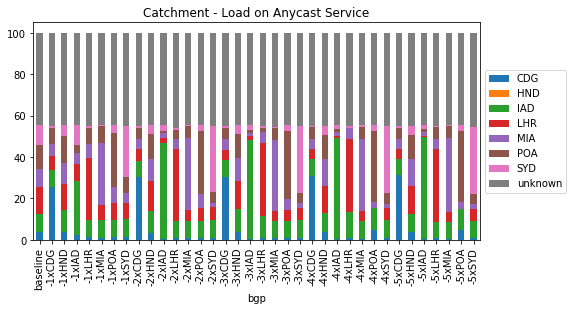

In [19]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data = data[data['num_prepend']<=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot2grid((1,1), (0,0))
data.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
ax.set_title("Catchment - Load on Anycast Service".format(site));  
data

## C. Impact of path prepending in catchment 

245800.0


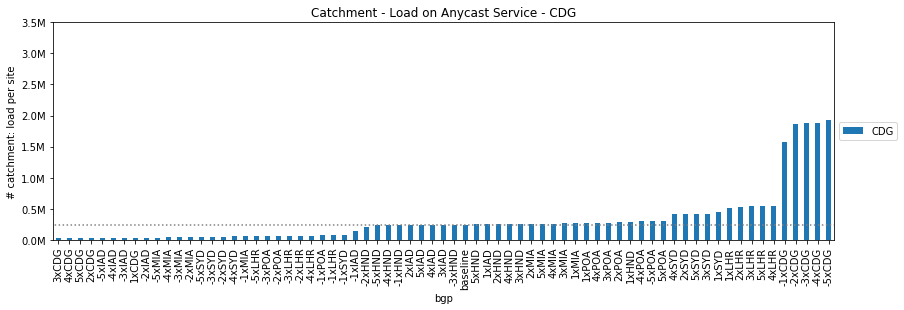

1.0


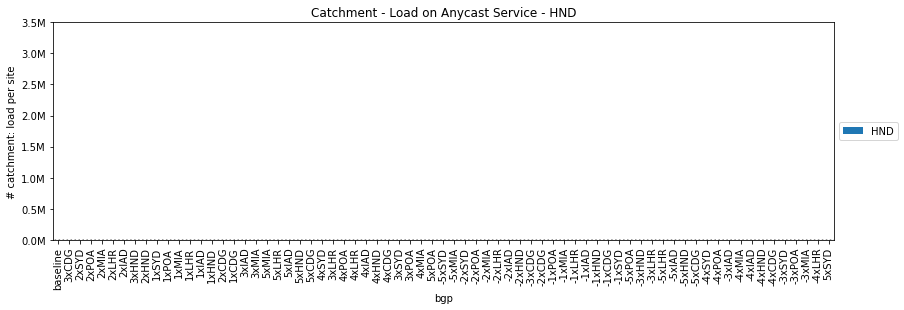

520290.0


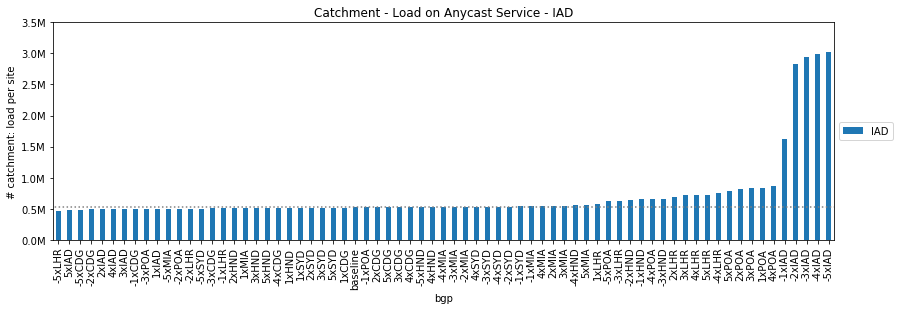

796172.0


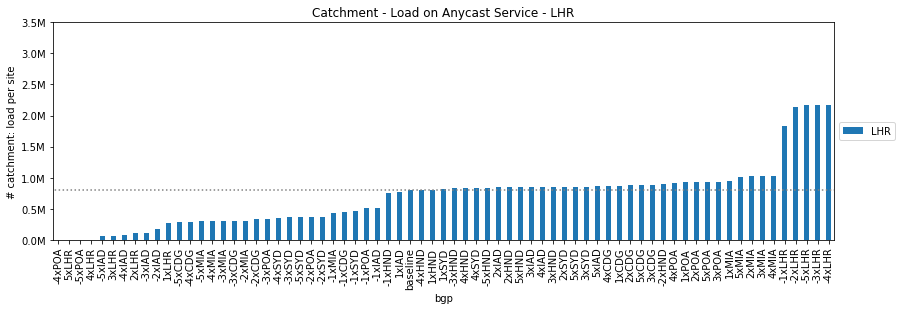

543614.0


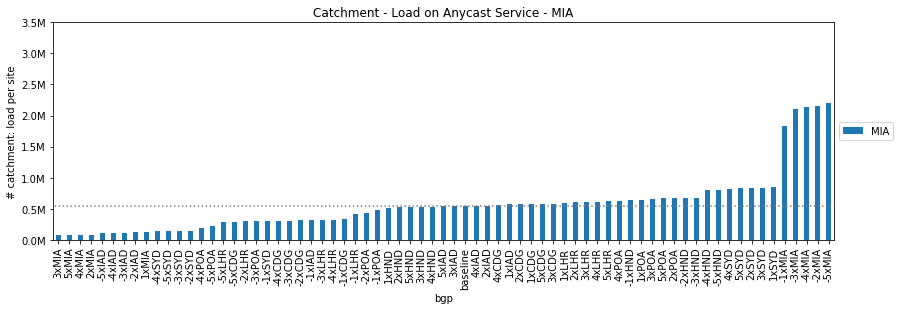

714439.0


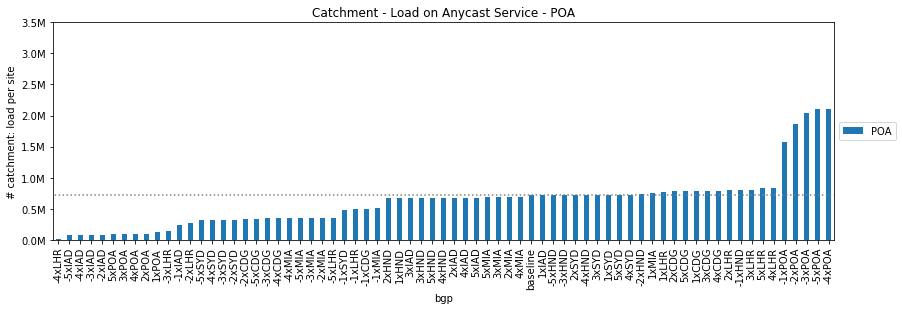

584351.0


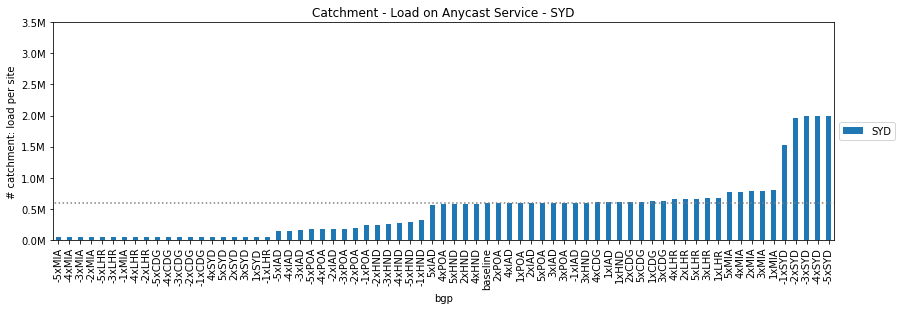

2750121.0


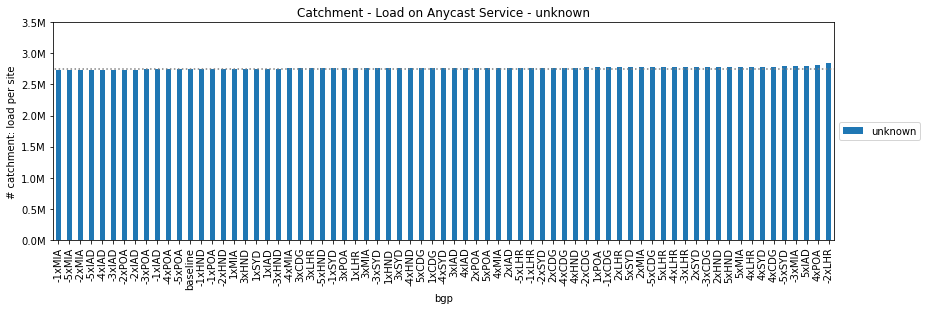

In [20]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
columns_name = data.columns.get_level_values(0)

for col in columns_name:
    
    fig = plt.figure(figsize=(14, 4))
    ax = plt.subplot2grid((1,1), (0,0))
    
    data_site = data.loc[:,col].sort_values()
#     data_site = data.loc[:,col] 

    data_site.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
    df_site = data_site.reset_index()
    reference_value = data_site.reset_index()[df_site.bgp=="baseline"].iloc[0,1]
    print (reference_value)

   # label = "[{}%] BASELINE".format(int(reference_value))
   # ax.annotate(label,xy=(25, reference_value), ha='right',color='black',va='bottom')
    ax.axhline(y=reference_value, xmin=-1, xmax=1.0, color='grey', linestyle='dotted')
    
    ax.set_ylim(ymax=3500000, ymin=0);
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
#     ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])

    ax.set_title("Catchment - Load on Anycast Service - {}".format(col));  
    ax.set_ylabel('# catchment: load per site');
    title = "<h2 style=\"color:#069\" >How prepending affects the load of site: {} </h2>".format(col.upper())
    display(HTML(title))
    plt.show()
    

## same values, another visualization

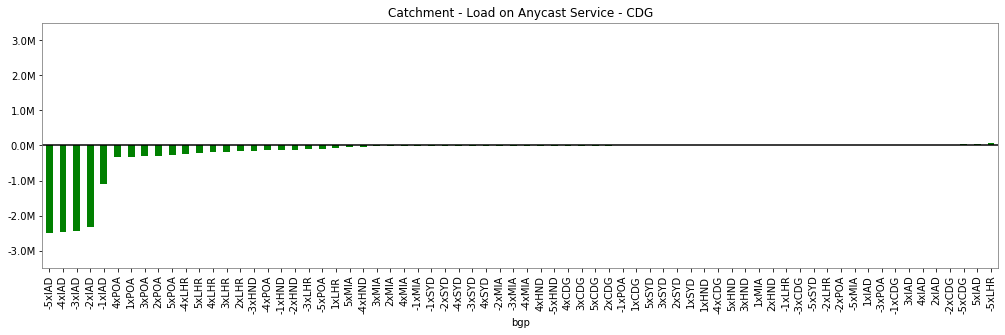

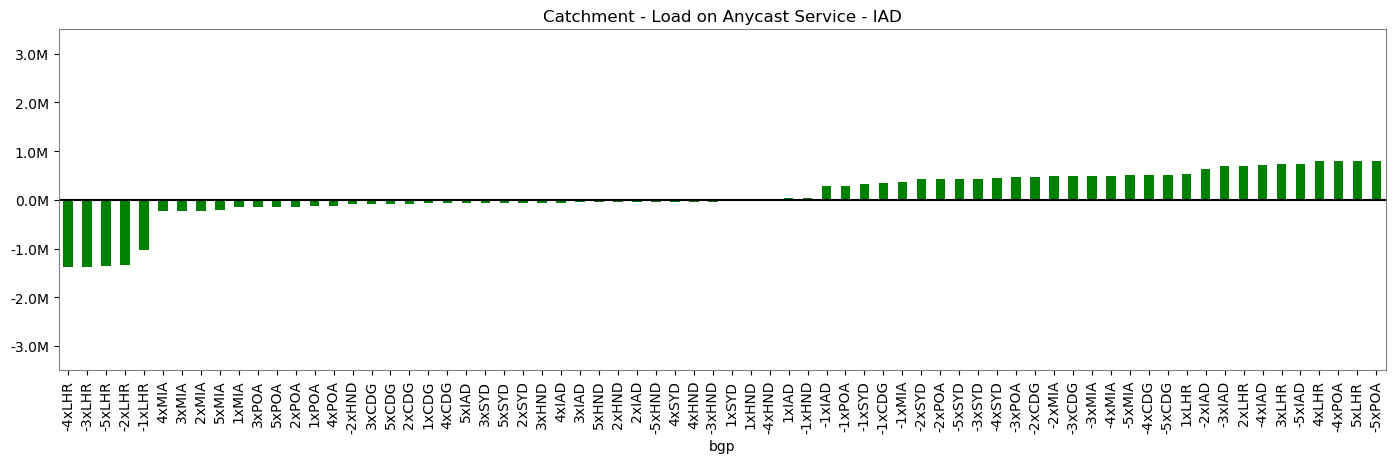

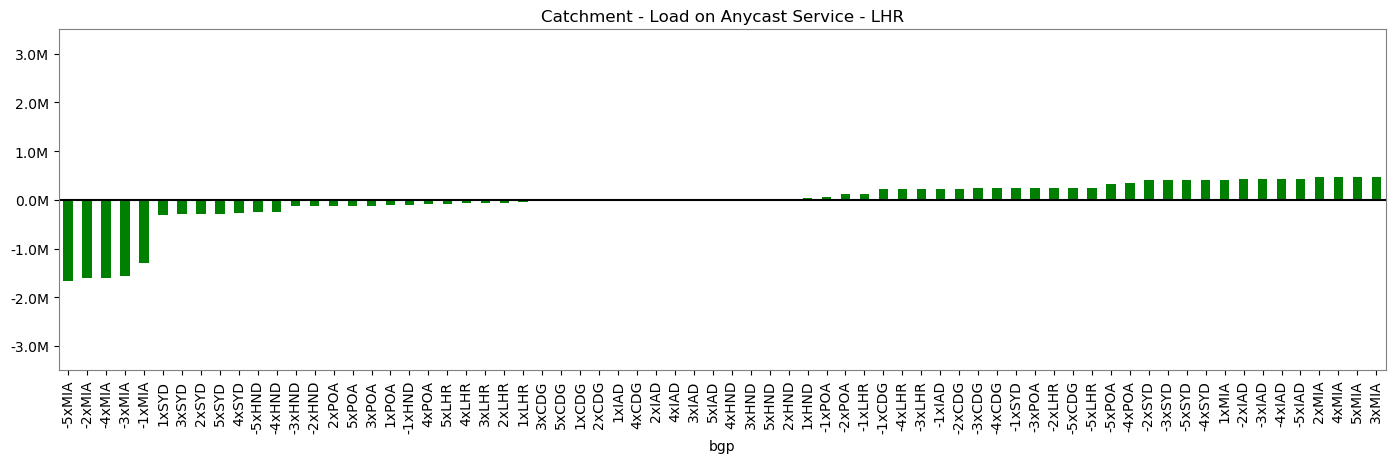

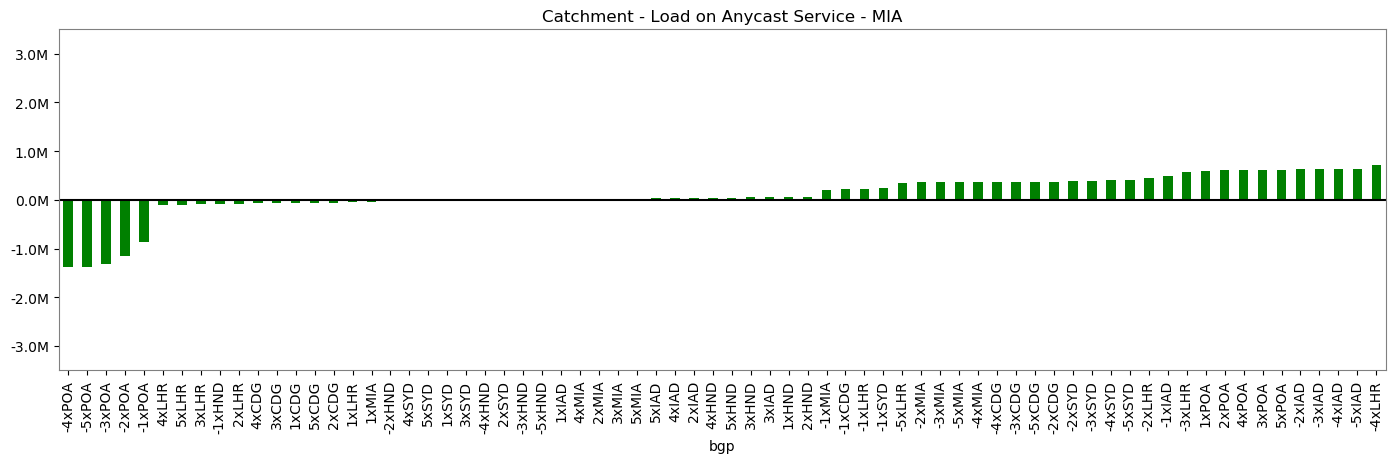

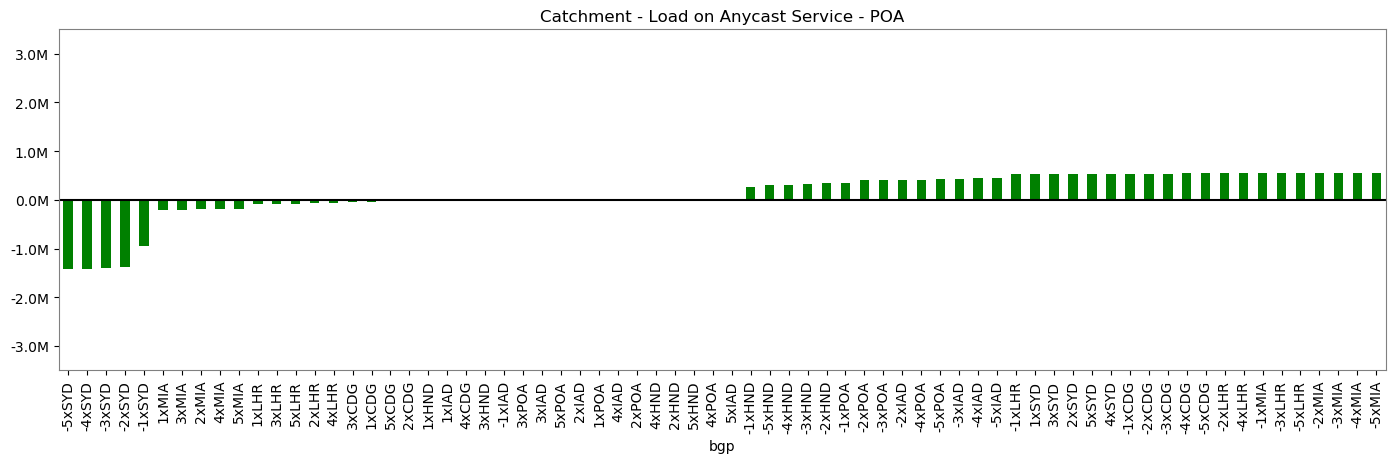

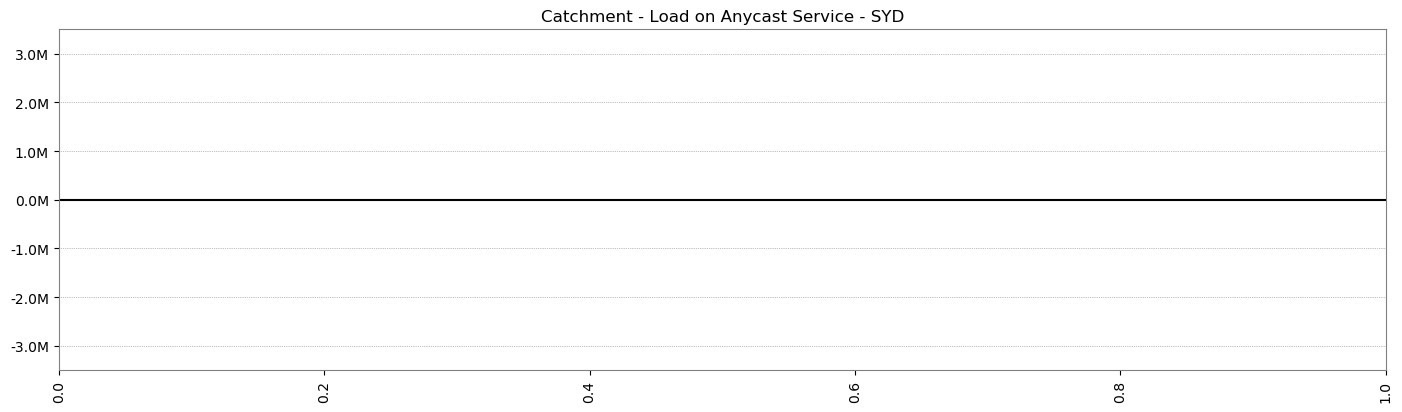

In [62]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")

data.drop('HND',1,inplace=True)
data.drop('unknown',1,inplace=True)    
columns_name = data.columns.get_level_values(0)

for site in columns_name:
    baseline  = data.iloc[[0]].values[0]
    data_diff = data.iloc[1:].apply(lambda x: (baseline-x), axis=1)  
    data_diff[site].sort_values().plot(kind="bar",ax=ax, stacked=False,color="green")

    (fig,ax) = init_fig(14,4)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels,rotation=90);
    ax.set_ylim(ymax=3500000,ymin=-3500000);
    ax.axhline(y=0, xmin=-1, xmax=1.0, color="black")
    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    ax.set_title("Catchment - Load on Anycast Service - {}".format(site)); 
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()]); 

## Leandro's Idea
## Anycast Service maximum and minimum

In [63]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")

# fix column names
data.columns=data.columns.get_level_values(0)
data.columns = data.columns.to_list()
df_prepend = data
df_prepend.head()

,CDG,HND,IAD,LHR,MIA,POA,SYD,unknown
bgp,,,,,,,,
baseline,245800.0,1.0,520290.0,796172.0,543614.0,714439.0,584351.0,2750121.0
-1xCDG,1566418.0,1.0,495453.0,443092.0,329853.0,497518.0,47549.0,2774904.0
-1xHND,235341.0,1.0,652208.0,759538.0,640007.0,801860.0,315584.0,2750249.0
-1xIAD,141394.0,1.0,1614949.0,507450.0,317966.0,231234.0,595158.0,2746636.0
-1xLHR,81971.0,1.0,508383.0,1829601.0,419133.0,492276.0,50899.0,2772524.0


In [64]:
data = pd.DataFrame()
regex_prepend_site = "prepend|baseline|with|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()

data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data.columns = data.columns.get_level_values(0).tolist()
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
data.to_csv("prepend+withdraw-dataframe.csv",sep=";")

In [65]:
data.head()

,CDG,HND,IAD,LHR,MIA,POA,SYD,unknown
bgp,,,,,,,,
baseline,245800.0,1.0,520290.0,796172.0,543614.0,714439.0,584351.0,2750121.0
-1xCDG,1566418.0,1.0,495453.0,443092.0,329853.0,497518.0,47549.0,2774904.0
-1xHND,235341.0,1.0,652208.0,759538.0,640007.0,801860.0,315584.0,2750249.0
-1xIAD,141394.0,1.0,1614949.0,507450.0,317966.0,231234.0,595158.0,2746636.0
-1xLHR,81971.0,1.0,508383.0,1829601.0,419133.0,492276.0,50899.0,2772524.0


In [67]:
data = pd.DataFrame()
regex_prepend_site = "prepend|baseline|with|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()

data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data.columns = data.columns.get_level_values(0).tolist()
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
data.to_csv("prepend+withdraw-dataframe-percent.csv",sep=";")
data.head()

,CDG,HND,IAD,LHR,MIA,POA,SYD,unknown
bgp,,,,,,,,
baseline,3.994,0.0,8.453,12.936,8.832,11.608,9.494,44.683
-1xCDG,25.450,0.0,8.050,7.199,5.359,8.083,0.773,45.085
-1xHND,3.824,0.0,10.597,12.341,10.399,13.028,5.127,44.685
-1xIAD,2.297,0.0,26.239,8.245,5.166,3.757,9.670,44.626
-1xLHR,1.332,0.0,8.260,29.726,6.810,7.998,0.827,45.047


In [24]:
pwd

'/Users/ceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load'

In [25]:
df[df['bgp_policy'].str.contains("withdraw-au-syd-anycast01")]

,site,count,percent,time,bgp_policy_location,num_prepend,community,bgp_policy
0,MIA,829334,13.475,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01
1,LHR,823306,13.377,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01
2,POA,724302,11.768,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01
3,IAD,519713,8.444,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01
4,CDG,470715,7.648,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01
5,HND,1,0.000,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01
6,unknown,2787417,45.289,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01


### Extract MAX/MIN/BASELINE from prepend dataframe for each node

In [26]:
# get max value per line
max_policy_label = data.T.idxmax(axis=1)
max_policy_value=data.T.max(axis=1)

# get min value per line
min_policy_label = data.T.idxmin(axis=1)
min_policy_value=data.T.min(axis=1)

# get baseline values
df_baseline = data.iloc[0,:]

# build dataframe
df_result = pd.concat([max_policy_value,
                       min_policy_value,
                       df_baseline,max_policy_label,
                       min_policy_label],
                       axis=1
                     ) 
df_result.columns=['max','min','baseline','max_label','min_label']
# remove nodes
df_result = df_result[df_result.index!="unknown"]
df_result = df_result[df_result.index!="HND"]

,max,min,baseline,max_label,min_label
CDG,1928542.0,0.0,245800.0,-5xCDG,0xCDG
IAD,3015529.0,0.0,520290.0,-5xIAD,0xIAD
LHR,2175304.0,0.0,796172.0,-4xLHR,-4xPOA
MIA,2203564.0,0.0,543614.0,-5xMIA,0xMIA
POA,2104090.0,0.0,714439.0,-4xPOA,0xPOA
SYD,1997357.0,0.0,584351.0,-5xSYD,0xSYD


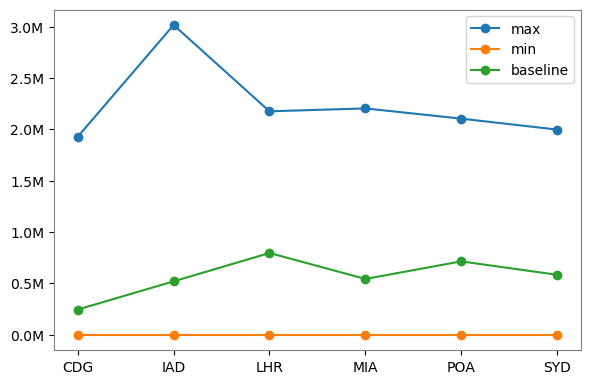

In [27]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)   
ax = plt.subplot2grid((1,1), (0,0))

ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
fig.tight_layout();
plt.style.use('default')

df_result[['max','min','baseline']].plot(marker='o',ax=ax)
ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])

df_result

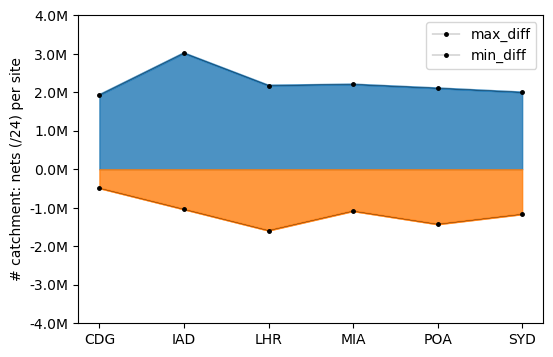

In [28]:
df_result['max_diff'] = (df_result['max'] - df_result['baseline'])   + df_result['baseline']
df_result['min_diff'] = (df_result['min'] - df_result['baseline'] ) - df_result['baseline']
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot2grid((1,1), (0,0))
df_result[['max_diff','min_diff']].plot(kind='area',ax=ax,alpha=0.8)
df_result[['min_diff']].plot(kind='line',marker=".",
                             markersize=5,
                             color="black",
                              linewidth=0.2,
                             ax=ax,legend=[])
df_result[['max_diff']].plot(kind='line',marker=".",
                             markersize=5,
                             color="black",
                              linewidth=0.2,
                             ax=ax,legend=[])
ax.set_ylim(ymax=4000000, ymin=-4000000);
ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()]);
ax.set_ylabel('# catchment: nets (/24) per site');
# ax2 = ax.twinx()
# ax.get_yticks().tolist()


In [29]:
# data_site.iloc[0:1][0]
# data_site[data_site.iloc[0]=="baseline"]

df_site = data_site.reset_index()
reference_value = data_site.reset_index()[df_site.bgp=="baseline"].iloc[0,1]
reference_value

2750121.0

---
---
<h1 align="center">Effect of prepeding on each site</h1>

---
---

In [30]:
available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

['CDG', 'IAD', 'LHR', 'MIA', 'POA', 'SYD']

CDG


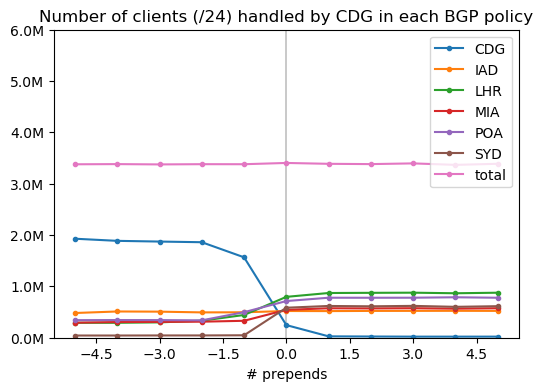

IAD


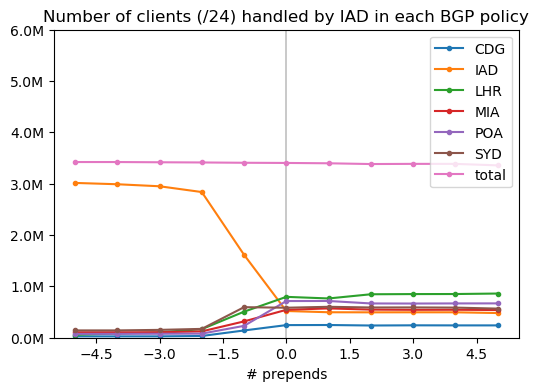

LHR


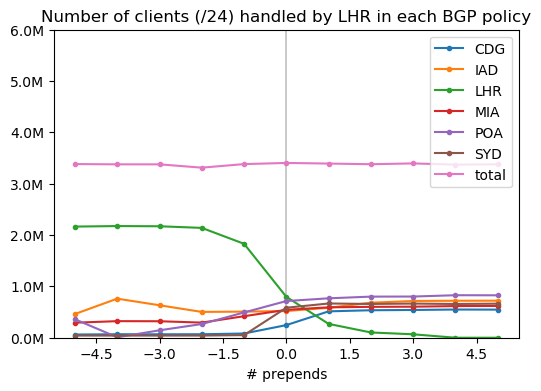

MIA


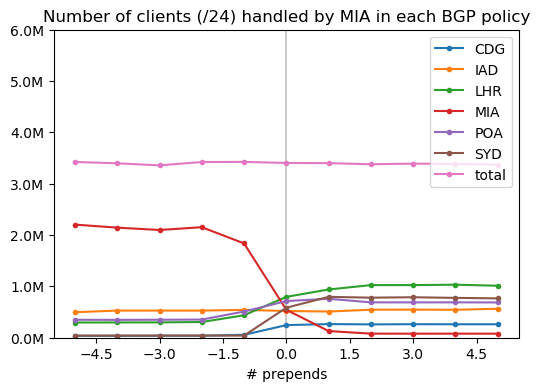

POA


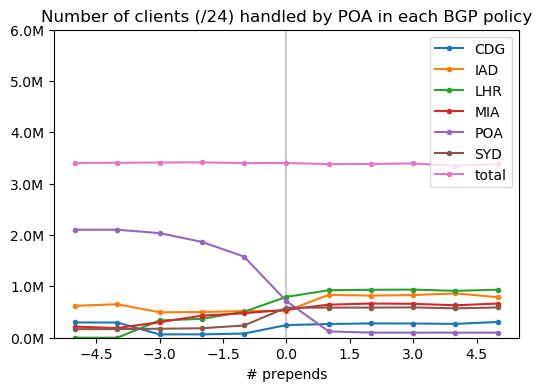

SYD


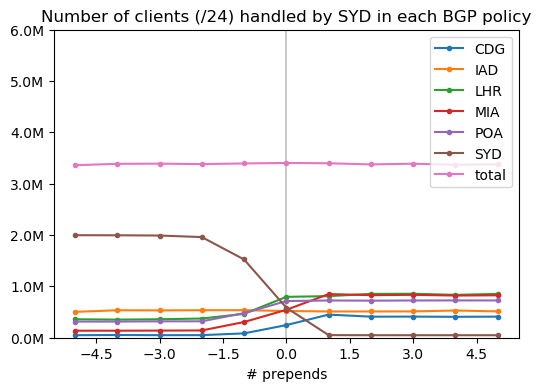

In [31]:
for prepend_site in available_nodes:

    data = df_prepend.copy()
    print (prepend_site)
    # prepare dataframe
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)]
    data.drop('HND',1,inplace=True)
    data.drop('unknown',1,inplace=True)
    data.reset_index(inplace=True)
    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    data['total'] = data.sum(axis=1)
    
    # prepare graph
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot(111)   
    ax.set_ylim(ymax=6000000);
    ax.axvline(x=0, color='black',linewidth=0.3)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    data.plot(kind="line",ax=ax, marker=".")
    ax.set_xlabel('# prepends');
    ax.set_title("Number of clients (/24) handled by {} in each BGP policy".format(prepend_site));   
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    plt.show()

---
---
<h1 align="center">Effect of self-prepending on all the sites</h1>

---
---

In [32]:
available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

['CDG', 'IAD', 'LHR', 'MIA', 'POA', 'SYD']

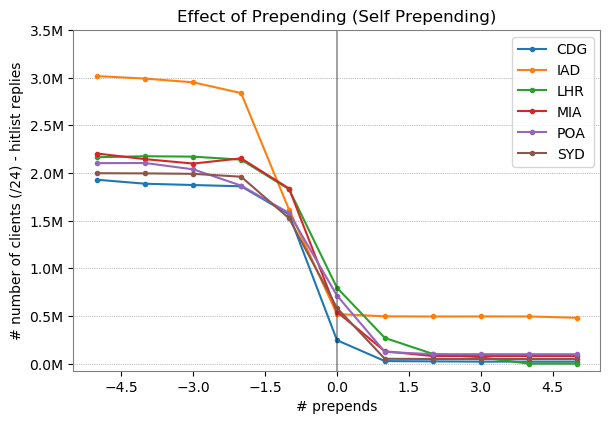

In [33]:
(fig,ax) = init_fig(6,4)
ax.set_title("Effect of Prepending (Self Prepending)")

for prepend_site in available_nodes:
# for prepend_site in  ['CDG']: 

    # prepare dataset
    data = df_prepend.copy()
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)][prepend_site]
    self_prepending = data
    data = data.reset_index()

    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    
    
    # plot graph
    data.plot(kind="line",
              marker=".",
              ax= ax)
    
    ax.set_ylim(ymax=3500000);
    ax.axvline(x=0, color='black',linewidth=0.1)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    ax.set_ylabel('# number of clients (/24) - hitlist replies');

    ax.set_xlabel('# prepends');

#     filename = "/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/self_prepending_tangled.pdf"
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
#     fig.savefig(filename, bbox_inches='tight', dpi=1200)

    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)

In [34]:
data = df_prepend.copy()
data.head()
data.drop('unknown',1,inplace=True)
data['total'] = data.sum(axis=1)
data
data_percent = pd.DataFrame()
data_percent['bgp'] = data.index
data = data.reset_index()
data_percent
data.head()

for node in data.columns[1:8]:
    node_pct = "{}_pct".format(node)
    data_percent[node] = (data[node]/data['total']).mul(100).round(3)
data_percent.head(1)
data_percent.set_index('bgp',inplace=True)

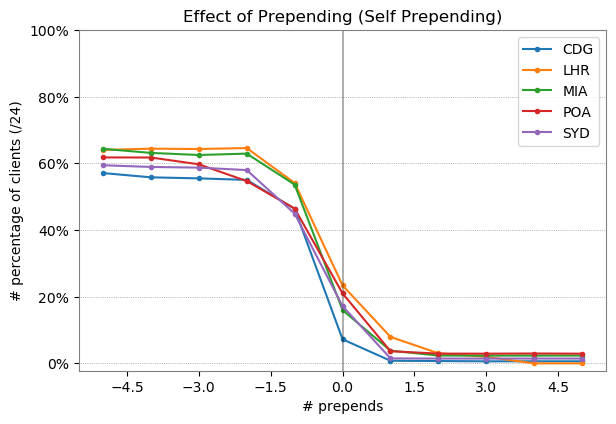

In [35]:
(fig,ax) = init_fig(6,4)
ax.set_title("Effect of Prepending (Self Prepending)")
available_nodes = ['CDG', 'LHR', 'MIA', 'POA', 'SYD']
# available_nodes = ['CDG', 'LHR']
for prepend_site in available_nodes:
# for prepend_site in  ['CDG']: 

    # prepare dataset
    data = data_percent.copy()
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)][prepend_site]
    self_prepending = data
    data = data.reset_index()

    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    
    
    # plot graph
    data.plot(kind="line",
              marker=".",
              ax= ax)
    
    ax.axvline(x=0, color='black',linewidth=0.1)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.set_ylabel('# percentage of clients (/24)');

    ax.set_xlabel('# prepends');
    ax.set_ylim(ymax=100);
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);

#     filename = "/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/self_prepending_tangled.pdf"
#     ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
#     fig.savefig(filename, bbox_inches='tight', dpi=1200)

    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)

---
---
<h1 align="center">Regular Prepending vs Community prepend</h1>

---
---

# VULTR

In [36]:
df_all.num_prepend = df_all.num_prepend.astype(int)
df_ampath = df_all[df_all['bgp_policy_location'].str.contains("ampath")].copy()
df_ampath_community = df_ampath[df_ampath.bgp_policy.str.contains("community")]
df_ampath_prepend = df_ampath[~df_ampath.bgp_policy.str.contains("community")]

In [37]:
# df_ampath_prepend

FileNotFoundError: [Errno 2] No such file or directory: '/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/ampath-prepending.pdf'

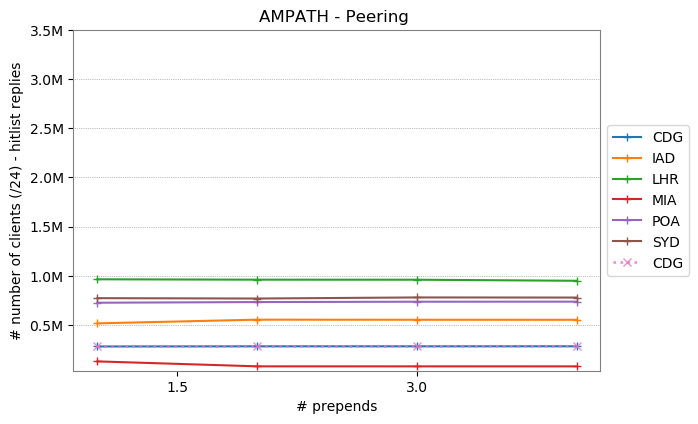

In [38]:

df_all.num_prepend = df_all.num_prepend.astype(int)
df_ampath = df_all[df_all['bgp_policy_location'].str.contains("ampath")].copy()
df_ampath_community = df_ampath[df_ampath.bgp_policy.str.contains("community")]
df_ampath_prepend = df_ampath[~df_ampath.bgp_policy.str.contains("community")]

available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

(fig,ax) = init_fig(6,4)

for prepend_site in available_nodes:
    
    data = df_ampath_community[df_ampath_community.site.str.contains(prepend_site)]
    a = pd.pivot_table(data,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
    data = a.T
    data.plot(kind="line",
                  marker="+",
                  ax= ax)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    

for prepend_site in available_nodes:
    
    data = df_ampath_prepend[df_ampath_prepend.site.str.contains(prepend_site)]
    a = pd.pivot_table(data,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
    data = a.T
    data.plot(kind="line",
                  marker="x",
                  ax= ax,
                  alpha = 1.8,
                  linestyle='dotted',
                  linewidth=1.9
             )
    ax.set_title("AMPATH - Peering "); 
    
    ax.set_ylim(ymax=3500000);
    ax.set_xlabel('# prepends');
    ax.set_ylabel('# number of clients (/24) - hitlist replies');
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    
    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    filename = "/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/ampath-prepending.pdf"
    fig.savefig(filename, bbox_inches='tight', dpi=1200)

In [ ]:

df_all.num_prepend = df_all.num_prepend.astype(int)
df_ampath = df_all[df_all['bgp_policy_location'].str.contains("vultr")].copy()
df_ampath_community = df_ampath[df_ampath.bgp_policy.str.contains("community")]
df_ampath_prepend = df_ampath[~df_ampath.bgp_policy.str.contains("community")]

available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

(fig,ax) = init_fig(6,4)

for prepend_site in available_nodes:
    
    data = df_ampath_community[df_ampath_community.site.str.contains(prepend_site)]
    a = pd.pivot_table(data,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
    data = a.T
    data.plot(kind="line",
                  marker="+",
                  ax= ax)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    

for prepend_site in available_nodes:
    
    data = df_ampath_prepend[df_ampath_prepend.site.str.contains(prepend_site)]
    a = pd.pivot_table(data,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
    data = a.T
    data.plot(kind="line",
                  marker="x",
                  ax= ax,
                  alpha = 1.8,
                  linestyle='dotted',
                  linewidth=1.9
             )
    ax.set_ylim(ymax=3500000);

    ax.set_title("VULTR  Peering");   
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.set_ylabel('# number of clients (/24) - hitlist replies');

    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    filename = "/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/vultr-prepending.pdf"
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    fig.savefig(filename, bbox_inches='tight', dpi=1200)